In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import struct
from scipy.special import expit
from sklearn.manifold import TSNE
from ast import literal_eval

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# !gunzip "/content/drive/My Drive/Colab Notebooks/ml-scratch-posts/data/train-images-idx3-ubyte.gz"

In [ ]:
# !gunzip "/content/drive/My Drive/Colab Notebooks/ml-scratch-posts/data/train-labels-idx1-ubyte.gz"

In [3]:
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [4]:
def read_fashion_mnist(images_path, labels_path):
    with open(labels_path, 'rb') as p:
        magic, n = struct.unpack('>II', p.read(8))
        labels = np.fromfile(p, dtype=np.uint8)
    with open(images_path, 'rb') as p:
        magic, num, rows, cols = struct.unpack(">IIII", p.read(16))
        images = np.fromfile(p, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


def mle(y, axis=1):
    return np.argmax(y, axis)


def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat

In [5]:
def L2_reg(lambda_, w1, w2):
    return (lambda_ / 2.0) * (np.sum(w1 ** 2) + np.sum(w2 ** 2))


def L1_reg(lambda_, w1, w2):
    return (lambda_ / 2.0) * (np.abs(w1).sum() + np.abs(w2).sum())


def cross_entropy(outputs, y_target):
    return -np.sum(np.log(outputs) * y_target, axis=1)

In [6]:
def plot_product(X, y, idx):
    img = X[idx].reshape(28,28)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title('true label: %s' % CLASS_NAMES[y[idx]])
    plt.colorbar()
    plt.grid(False)
    plt.show()

def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()

In [7]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAMES[predicted_label],
                                100*np.max(predictions_array),
                                CLASS_NAMES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def plot_image_grid(X_test, y_test, y_hat, num_rows=5, num_cols=3):
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_hat, y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_hat,  y_test)

# Image data

## Reading images

In [8]:
IMAGES_PATH = '/content/drive/My Drive/Colab Notebooks/ml-scratch-posts/data/train-images-idx3-ubyte'
LABELS_PATH = '/content/drive/My Drive/Colab Notebooks/ml-scratch-posts/data/train-labels-idx1-ubyte'

N_FEATURES = 28 * 28 # 28x28 pixels for the images
N_CLASSES = 10

In [9]:
X, y = read_fashion_mnist(IMAGES_PATH, LABELS_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Exploration

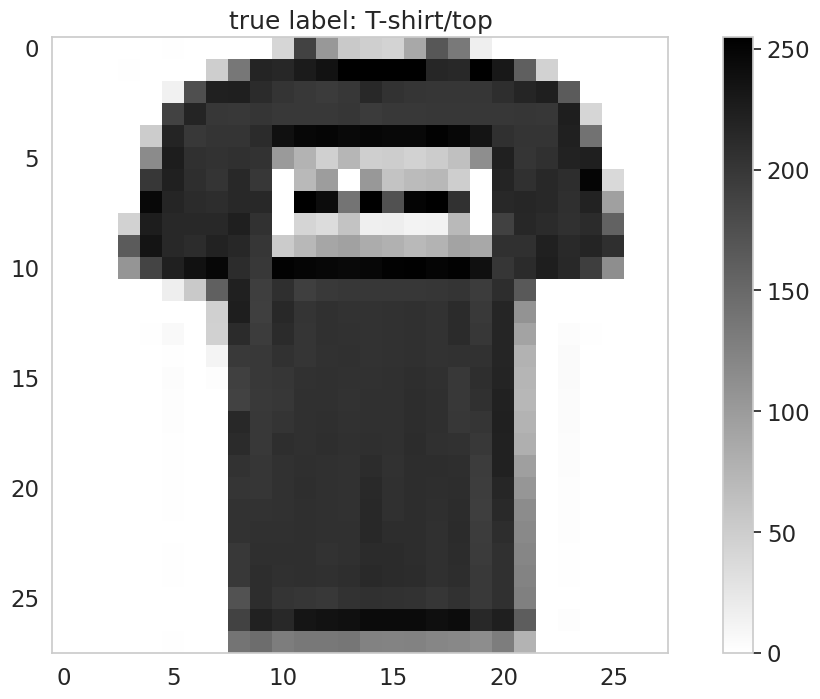

In [10]:
plot_product(X, y, idx=1)

In [ ]:
X[1].reshape(28, 28)

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

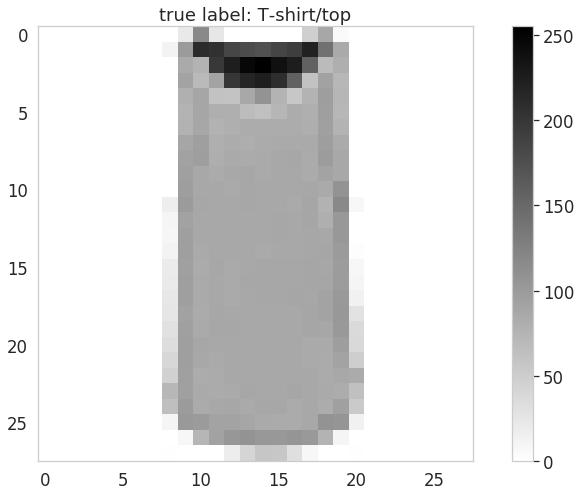

In [ ]:
plot_product(X, y, idx=2)

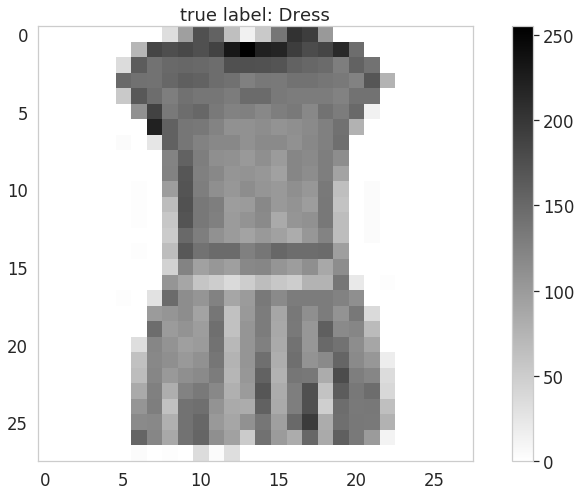

In [ ]:
plot_product(X, y, idx=3)

In [ ]:
X_test_tsne = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(X_test)

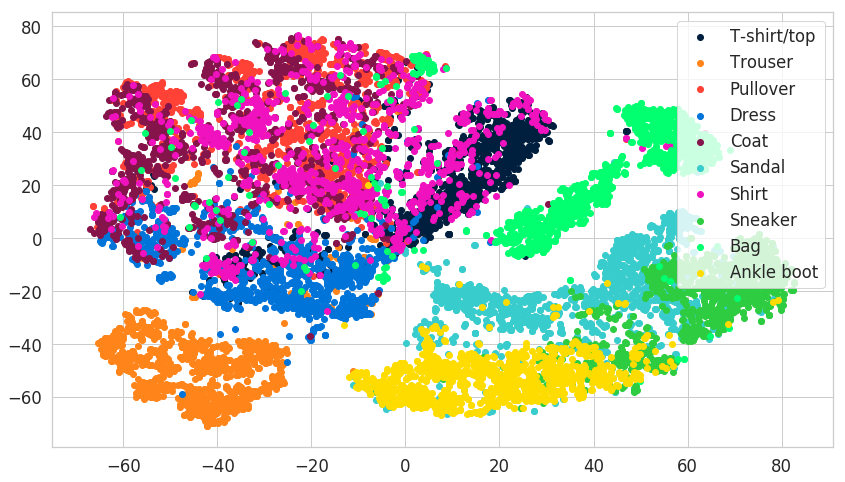

In [ ]:
colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)',
'rgb(76,114,176)', 'rgb(85,168,104)', 'rgb(129,114,178)', 'rgb(100,181,205)']

def plot_embedding_v1(X_embeded, y):
    for k, i in enumerate(np.unique(y.astype(np.int))):
        plt.scatter(X_embeded[y == i, 0],
                   X_embeded[y == i, 1],
                   color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),
                    label = CLASS_NAMES[k])
    plt.legend()
    plt.show()

plot_embedding_v1(X_test_tsne, y_test)


# Background

## Sigmoid (and it's derivative)

$$\sigma (x) = \frac{1}{1+e^{-x}}$$



In [ ]:
def sigmoid(z):
    # return 1.0 / (1.0 + np.exp(-z))
    return expit(z)

### First derivative of Sigmoid

$$\frac{d\sigma (x)}{d(x)} = \sigma (x)\cdot (1-\sigma(x))$$

In [ ]:
def sigmoid_prime(z):
    sg = sigmoid(z)
    return sg * (1 - sg)

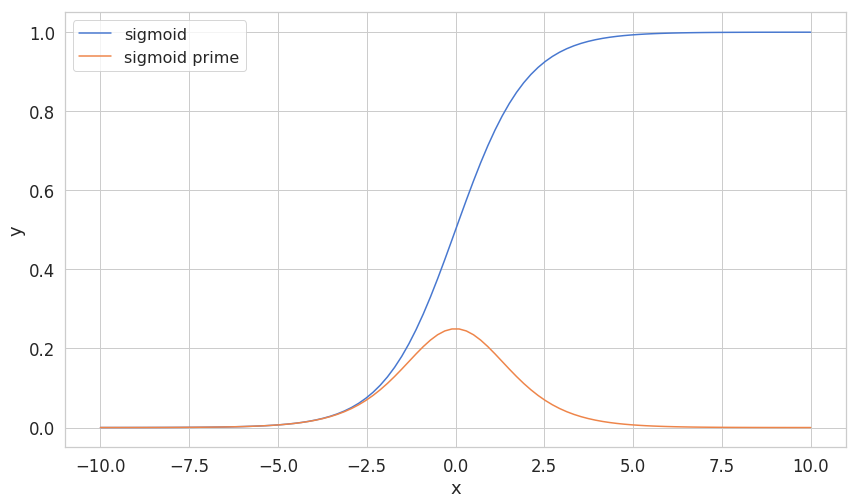

In [ ]:
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)
sig_prime = sigmoid_prime(x)

plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

## Softmax


$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{K}^{k=1}e^{z_k}} \text{for}\,j = 1,...,k$$

In [ ]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [ ]:
softmax(np.array([[2, 4, 6, 8]]))

array([[0.00214401, 0.0158422 , 0.11705891, 0.86495488]])

NumPy is pretty useful. You just have to be careful with the dimensions!

## Backpropagation

### XOR

| Input 1 	| Input 2 	| Output 	|
|---------	|---------	|--------	|
| 0       	| 0       	| 0      	|
| 0       	| 1       	| 1      	|
| 1       	| 0       	| 1      	|
| 1       	| 1       	| 0      	|


<img src="https://wantee.github.io/assets/images/posts/xor.png" width="60%">

In [ ]:
epochs = 50000
input_size, hidden_size, output_size = 2, 3, 1
LR = .1 # learning rate

In [ ]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([ [0],   [1],   [1],   [0]])

In [ ]:
w_hidden = np.random.uniform(size=(input_size, hidden_size))
w_output = np.random.uniform(size=(hidden_size, output_size))

### Training

In [ ]:
for epoch in range(epochs):

    # Forward
    act_hidden = sigmoid(np.dot(X, w_hidden))
    output = np.dot(act_hidden, w_output)

    # Calculate error
    error = y - output

    if epoch % 5000 == 0:
        print(f'error sum {sum(error)}')

    # Backward
    dZ = error * LR
    w_output += act_hidden.T.dot(dZ)
    dH = dZ.dot(w_output.T) * sigmoid_prime(act_hidden)
    w_hidden += X.T.dot(dH)

error sum [-1.77496016]
error sum [0.00586565]
error sum [0.00525699]
error sum [0.0003625]
error sum [-0.00064657]
error sum [0.00189532]
error sum [3.79101849e-08]
error sum [7.4162898e-13]
error sum [1.3211654e-14]
error sum [1.3211654e-14]


### Prediction

In [ ]:
test_data = X[1] # [0, 1]

act_hidden = sigmoid(np.dot(test_data, w_hidden))
np.dot(act_hidden, w_output)

array([1.])

# Neural Network Image Classifier


## Model implementation

In [ ]:
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30,
                 l1=0.0, l2=0.0, epochs=500, learning_rate=0.01,
                 n_batches=1, random_seed=None):

        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_batches = n_batches

    def _init_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_hidden_units, self.n_features))
        w2 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_classes, self.n_hidden_units))
        return w1, w2

    def _forward(self, X):
        net_input = X.copy()
        net_hidden = self.w1.dot(net_input.T)
        act_hidden = sigmoid(net_hidden)
        net_out = self.w2.dot(act_hidden)
        act_out = sigmoid(net_out)
        return net_input, net_hidden, act_hidden, net_out, act_out

    def _backward(self, net_input, net_hidden, act_hidden, act_out, y):
        sigma3 = act_out - y
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_prime(net_hidden)
        grad1 = sigma2.dot(net_input)
        grad2 = sigma3.dot(act_hidden.T)
        return grad1, grad2

    def _error(self, y, output):
        L1_term = L1_reg(self.l1, self.w1, self.w2)
        L2_term = L2_reg(self.l2, self.w1, self.w2)
        error = cross_entropy(output, y) + L1_term + L2_term
        return 0.5 * np.mean(error)

    def _backprop_step(self, X, y):
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(X)
        y = y.T

        grad1, grad2 = self._backward(net_input, net_hidden, act_hidden, act_out, y)

        # regularize
        grad1 += (self.w1 * (self.l1 + self.l2))
        grad2 += (self.w2 * (self.l1 + self.l2))

        error = self._error(y, act_out)

        return error, grad1, grad2

    def predict(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return mle(net_out.T)

    def predict_proba(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return softmax(act_out.T)

    def fit(self, X, y):
        self.error_ = []
        X_data, y_data = X.copy(), y.copy()
        y_data_enc = one_hot(y_data, self.n_classes)

        X_mbs = np.array_split(X_data, self.n_batches)
        y_mbs = np.array_split(y_data_enc, self.n_batches)

        for i in range(self.epochs):

            epoch_errors = []

            for Xi, yi in zip(X_mbs, y_mbs):

                # update weights
                error, grad1, grad2 = self._backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
        return self

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

## Training

In [ ]:
nn = NNClassifier(
    n_classes=N_CLASSES,
    n_features=N_FEATURES,
    n_hidden_units=50,
    l2=0.5,
    l1=0.0,
    epochs=300,
    learning_rate=0.001,
    n_batches=25,
    random_seed=RANDOM_SEED
).fit(X_train, y_train);

## Evaluation

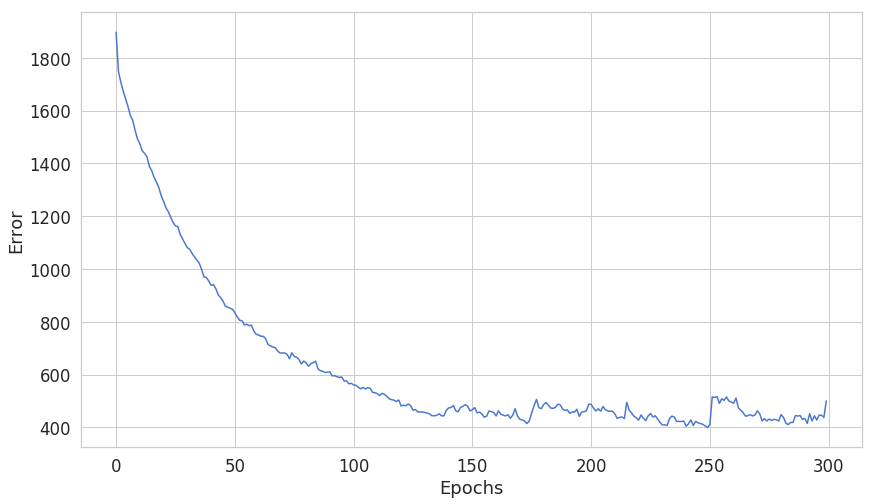

In [ ]:
plot_error(nn)

In [ ]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 50.13%
Test Accuracy: 49.83%


### Exploring predictions

In [ ]:
nn.predict_proba(X_test[1:2])

array([[0.08029   , 0.07921015, 0.10934666, 0.0798501 , 0.07984974,
        0.11261559, 0.14329481, 0.08037716, 0.15574595, 0.07941985]])

In [ ]:
y_hat = nn.predict_proba(X_test)

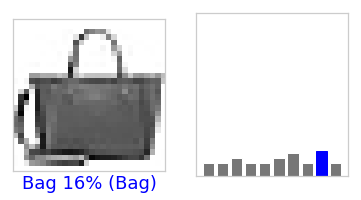

In [ ]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, y_hat, y_test, X_test)
plt.subplot(1, 2, 2)
plot_value_array(i, y_hat,  y_test)

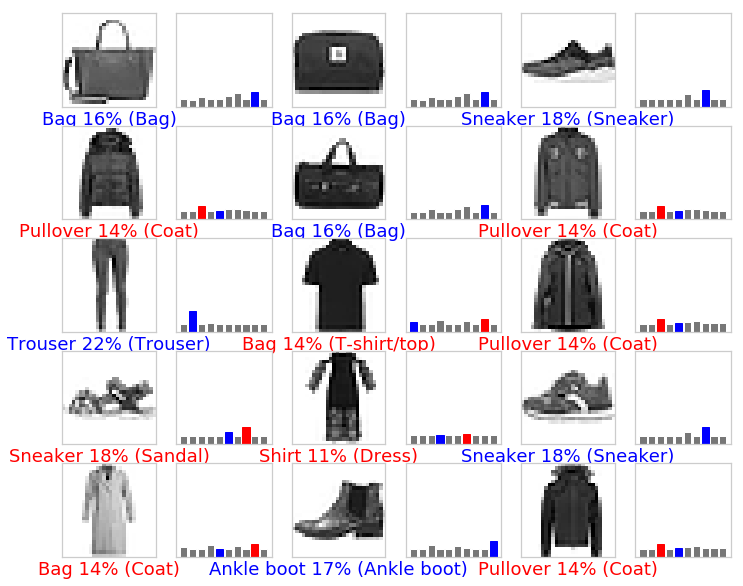

In [ ]:
plot_image_grid(X_test, y_test, y_hat)

### MLE = picking the most probable digit

In [ ]:
mle(nn.predict_proba(X_test[:5]))

array([8, 8, 7, 2, 8])

In [ ]:
nn.predict(X_test[:5])

array([8, 8, 7, 2, 8])

# Improving the predictions

In [ ]:
from sklearn.preprocessing import scale

X_train_scaled = scale(X_train.astype(np.float64))
X_test_scaled = scale(X_test.astype(np.float64))

nn = NNClassifier(
    n_classes=N_CLASSES,
    n_features=N_FEATURES,
    n_hidden_units=50,
    l2=0.5,
    l1=0.0,
    epochs=300,
    learning_rate=0.001,
    n_batches=25,
    random_seed=RANDOM_SEED
).fit(X_train_scaled, y_train);

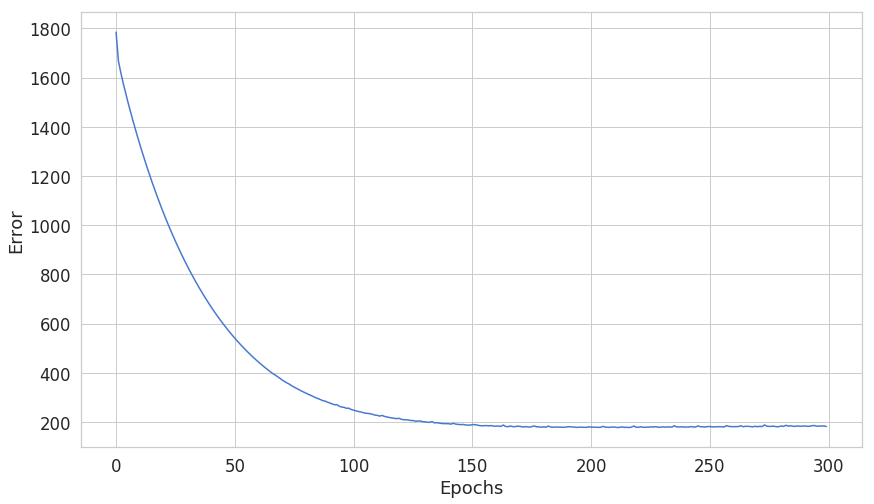

In [ ]:
plot_error(nn)

In [ ]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train_scaled, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test_scaled, y_test) * 100))

Train Accuracy: 92.13%
Test Accuracy: 87.03%


In [ ]:
y_hat = nn.predict_proba(X_test_scaled)

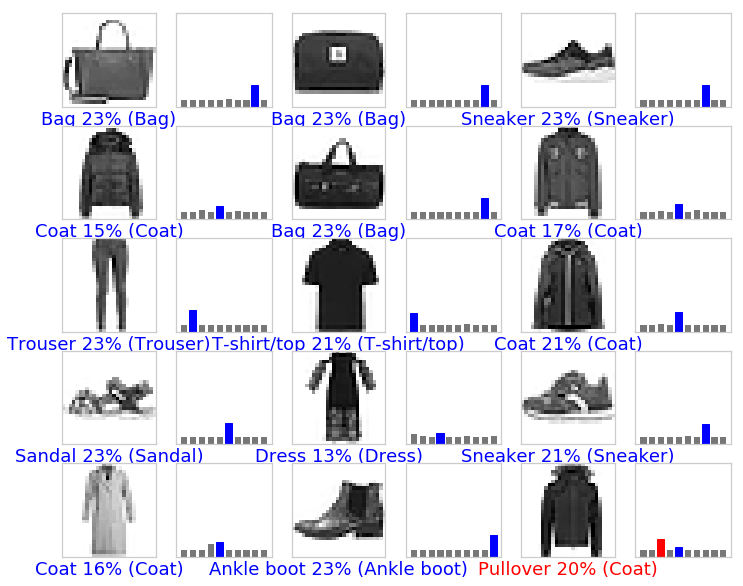

In [ ]:
plot_image_grid(X_test, y_test, y_hat)